In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import dask
import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
from xhistogram.xarray import histogram

from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [3]:
run_dedalus = False # Dedalus only works on login nodes; MITgcm analysis has to work on compute nodes.

In [4]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 60.

### Run / load 1D Dedalus simulations

In [5]:
T = 5000*86400
names = ['default', 'f=0', 'Pr=230']

bbl_runs = {
    'default': {},
    'f=0': {'f': 0.},
    'Pr=230': {'σ': 230.},
    'theta=0': {'θ': 0.}
}
bbl_output = {}

for name, kwargs in bbl_runs.items():
    if run_dedalus:
        from bbl import *
        for t in np.arange((200*86400), T, (200*86400)):
            path = f"../../data/dedalus/transient/BBTRE-{name}_{t}.nc"
            bbl = bbl_exp_spinup(T=t, dt=T/100., **kwargs)
            bbl_output[name] = bbl_to_ds(bbl).expand_dims(dim={'time': np.array([t])})
            bbl_output[name].to_netcdf(path)

    else:
        path = f"../../data/dedalus/transient/BBTRE-{name}_*.nc"
        pathstr = path.split("/")[-1]
        print(f"Loading {pathstr}")
        bbl_output[name] = xr.open_mfdataset(path, combine="by_coords", concat_dim='time')
        bbl_output[name]['time'] = bbl_output[name]['time']/86400.

Loading BBTRE-default_*.nc
Loading BBTRE-f=0_*.nc
Loading BBTRE-Pr=230_*.nc
Loading BBTRE-theta=0_*.nc


#### Pre-process 3D MITgcm output

In [6]:
nsnap = 24
dIter = 2*8640000//60

data_dir = f"../../MITgcm/experiments/rotated_BBTRE_idealized-plane/run_spinup/"

iters = np.arange(dIter, dIter+nsnap*dIter, dIter)
temp = open_mdsdataset(data_dir, iters=iters, ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
temp = add_thalweg(temp)
temp, grid = add_rotated_coords(temp, θ)
temp['time'] = temp['time'].astype(np.float64)*(1.e-9/86400.)
temp['dBdz'] = -g/ρ0*temp['DRHODR']+g*α*Γ
temp = temp.assign_coords({'Z_shift':temp.coords['Z']+3.0})

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


In [10]:
iters = np.arange(dIter//2, dIter//2+nsnap*dIter, dIter)
budget = open_mdsdataset(data_dir, iters=iters, ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
budget, _ = add_rotated_coords(budget, θ)
eddies = budget['ADVr_TH'].mean(['XC', 'YC']).sel(Zl=150., method='nearest').load()

wb = grid.interp(temp['WVEL'], 'Z', boundary='fill')*(g*α*temp['THETA'])
wb_profile = wb.mean(['XC', 'YC']).load()
wb_int = (wb_profile*wb.drF).sum("Z").load()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


(0.0, 500.0)

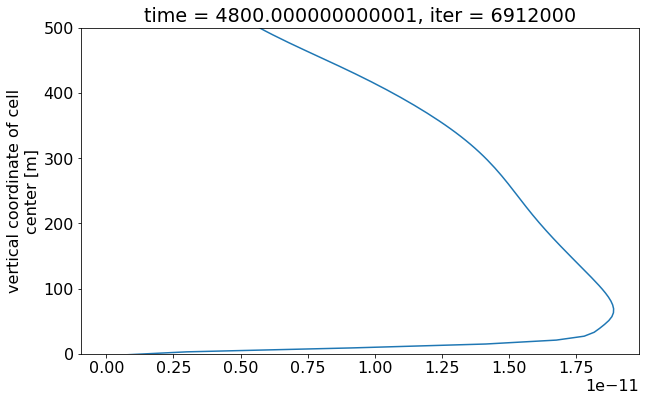

In [44]:
wb_profile.isel(time=-1).plot(y="Z")
plt.ylim(0, 500)

#### Pre-process 3D MITgcm output

In [63]:
nsnap = 24
dIter = 2*8640000//60

data_dir = f"../../MITgcm/experiments/rotated_BBTRE_idealized-plane-1D/run_spinup/"

iters = np.arange(dIter, dIter+nsnap*dIter, dIter)
temp_1d = open_mdsdataset(data_dir, iters=iters, ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
temp_1d = add_thalweg(temp_1d)
temp_1d, grid_1d = add_rotated_coords(temp_1d, θ)
temp_1d['time'] = temp_1d['time'].astype(np.float64)*(1.e-9/86400.)
temp_1d['dBdz'] = -g/ρ0*temp_1d['DRHODR']+g*α*Γ
temp_1d = temp_1d.assign_coords({'Z_shift':temp_1d.coords['Z']+3.0})

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/pandas/core/indexes/base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


### Plot comparison

<ipython-input-64-5662c2a48b76>:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


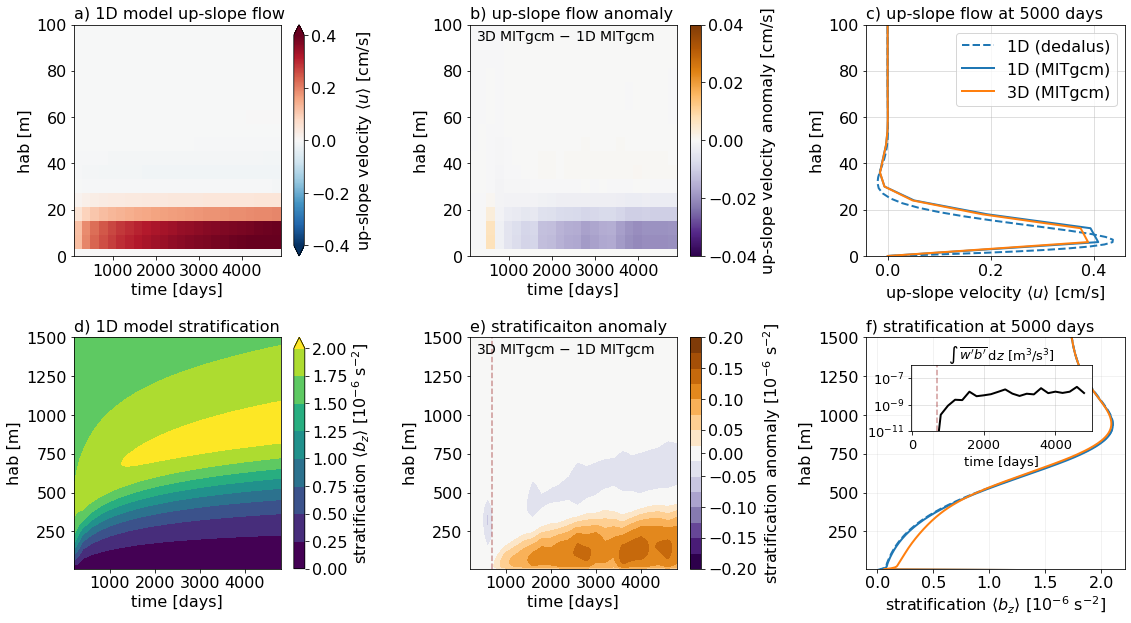

In [64]:
time = -1
Nsqlevels = np.arange(0., 2.25, 2.5e-1)
xyann = (0.03, 0.93)
xticks = np.arange(1000, 5000, 1000)

fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(2, 3)

### XY
ax = fig.add_subplot(gs[0, 0])
q = (temp_1d['UVEL'].isel(YC=0, XG=0)*100).plot(ax=ax, x='time', y="Z_shift", label = r"up-slope velocity $\langle u \rangle$ [cm/s]", vmin=-0.4, vmax=0.4, cmap='RdBu_r', extend='both')
q.colorbar.set_label(r"up-slope velocity $\langle u \rangle$ [cm/s]")
ax.set_ylim([0,100])
ax.set_ylabel("hab [m]")
ax.set_xlabel("time [days]")
ax.set_xticks(xticks)
ax.set_title("a) 1D model up-slope flow", loc='left', fontsize=16)
ax.set_title("")

ax = fig.add_subplot(gs[0, 1])
q = ((temp['UVEL'].mean(['XG', 'YC']) - temp_1d['UVEL'].isel(YC=0, XG=0))*100).plot(ax=ax, x='time', y="Z_shift", cmap='PuOr_r', vmin=-0.04, vmax=0.04)
q.colorbar.set_label(r"up-slope velocity anomaly [cm/s]")
ax.set_ylim([0,100])
ax.set_ylabel("hab [m]")
ax.set_xlabel("time [days]")
ax.set_xticks(xticks)
ax.annotate(r"3D MITgcm $-$ 1D MITgcm", xy=xyann, xycoords='axes fraction', fontsize=14)
ax.set_title("b) up-slope flow anomaly", loc='left', fontsize=16)
ax.set_title("")

ax = fig.add_subplot(gs[0, 2])
(bbl_output['default']['u']*100).isel(time=time).plot(ax=ax, y='Z', label='1D (dedalus)', lw=2., color="C0", linestyle="--")
(temp_1d['UVEL'].isel(YC=0, XG=0)*100).isel(time=time).plot(ax=ax, y='Z_shift', label='1D (MITgcm)', lw=2., color="C0", linestyle="-")
(temp['UVEL']*100).mean(['XG', 'YC']).isel(time=time).plot(ax=ax, y='Z_shift', label='3D (MITgcm)', lw=2., color="C1")
ax.set_ylim([0,100])
ax.set_title("")
ax.set_ylabel("hab [m]")
ax.set_xlabel(r"up-slope velocity $\langle u \rangle$ [cm/s]")
ax.grid(True, alpha=0.5)
ax.legend()
ax.set_title("c) up-slope flow at 5000 days", loc='left', fontsize=16)

ax = fig.add_subplot(gs[1, 0])
q = (temp_1d['dBdz'].isel(YC=0, XC=0)*1e6).plot.contourf(ax=ax, x='time', cmap="viridis", levels=Nsqlevels)
q.colorbar.set_label(r"stratification $\langle b_{z} \rangle$ [10$^{-6}$ s$^{-2}$]")
ax.set_ylim([10,1500])
ax.set_ylabel("hab [m]")
ax.set_xlabel("time [days]")
ax.set_xticks(xticks)
ax.set_title("d) 1D model stratification", loc='left', fontsize=16)
ax.set_title("")

ax = fig.add_subplot(gs[1, 1])
dN2 = 0.025; Nsqlevels_sym = np.append(np.arange(-0.2, 0., dN2), np.arange(dN2, 0.2+dN2, dN2))
q = ((temp['dBdz'].mean(['XC', 'YC']) - temp_1d['dBdz'].isel(YC=0, XC=0))*1e6).plot.contourf(ax=ax, x='time', cmap="PuOr_r", levels=Nsqlevels_sym)
q.colorbar.set_label(r"stratification anomaly [10$^{-6}$ s$^{-2}$]")
q.colorbar.set_ticks(np.arange(-0.2, 0.2+dN2, dN2*2))
ax.set_ylim([10,1500])
ax.set_ylabel("hab [m]")
ax.set_xlabel("time [days]")
ax.axvline(700., color='darkred', linestyle='--', alpha=0.4)
ax.set_xticks(xticks)
ax.annotate(r"3D MITgcm $-$ 1D MITgcm", xy=xyann, xycoords='axes fraction', fontsize=14)
ax.set_title("e) stratificaiton anomaly", loc='left', fontsize=16)
ax.set_title("")

ax = fig.add_subplot(gs[1, 2])
(bbl_output['default']['bz']*1e6).isel(time=time).plot(ax=ax, y='Zl', lw=2., color="C0", linestyle="--")
(temp_1d['dBdz'].isel(YC=0, XC=0)*1e6).isel(time=time).plot(ax=ax, y='Zl', lw=2., color="C0", linestyle="-")
(temp['dBdz'].mean(['XC', 'YC'])*1e6).isel(time=time).plot(ax=ax, y='Zl', lw=2., color="C1")
ax.set_ylim([10,1500])
ax.set_ylabel("hab [m]")
ax.set_xlabel(r"stratification $\langle b_{z} \rangle$ [10$^{-6}$ s$^{-2}$]")
ax.set_title("")
ax.grid(True, alpha=0.2)
ax.set_title("f) stratification at 5000 days", loc='left', fontsize=16)

axins = plt.axes([0, 0, 1, 1])
axins.set_alpha(0.5)
ip = InsetPosition(ax, [0.175, 0.595, 0.7, 0.285]) #posx, posy, width, height
axins.set_axes_locator(ip)
wb_int.plot(ax=axins, x='time', yscale='log', color='k', lw=2.)
axins.axvline(700., color='darkred', linestyle='--', alpha=0.4)
axins.set_title("")
axins.grid(True, alpha=0.4)
axins.set_ylabel("")
axins.set_title(r"$\int\, \overline{w'b'}\,$d$z$ [m$^{3}$/s$^{3}$]", fontsize=13)
axins.set_xlabel("time [days]", fontsize=13)
axins.set_ylim([1.e-11, 1.e-6])
axins.set_yticks([1.e-11, 1.e-9, 1.e-7])
axins.tick_params(labelsize=13)

plt.tight_layout()
plt.savefig("../../figures/BBTRE/1D_3D_comparison.png", bbox_inches='tight', dpi=150.)